In [1]:
import numpy as np
import torch
import sklearn
import tensorflow as tf

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [3]:
y = mnist.target
x = mnist.data
print(type(y))
print(x.shape)

<class 'numpy.ndarray'>
(70000, 784)


In [4]:
x = x.reshape((70000, 28, 28))

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 17)
x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size=0.2, random_state=40)
print('%d train, %d validation, %d test data' % (len(x_train), len(x_val), len(x_test)))

39200 train, 9800 validation, 21000 test data


In [7]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):

        super(AutoEncoder, self).__init__()


        self.encoder = torch.nn.Sequential(                                         # B 1  28 28
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),             # B 32 26 26
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),            # B 32 24 24
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                 # B 32 12 12

            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),            # B 64 10 10
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),            # B 64 8  8
            torch.nn.ReLU(),

            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),         # B 64 4  4

        )
            
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0),   # B 64 8  8      
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0),   # B 64 16 16
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),   # B 32 32 32
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),            # B 32 30 30
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=0),             # B 1  28 28
            torch.nn.ELU()
        )


        self.loss_function = torch.nn.MSELoss()

        self.batch_placeholder = torch.zeros(size=[1, 1, 28, 28], dtype=torch.float32, device=torch.device('cuda:0'))

        self.decider = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(8 * 8 * 64, 128), # B 64
            torch.nn.ELU(),
            torch.nn.Linear(128, 10) # B 10
        )


    def forward(self, batch):
        encoded = self.encoder(batch)
        decoded = self.decoder(encoded)

        loss = self.loss_function(decoded, batch)

        return decoded, loss
    
        

In [8]:
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [9]:
model = AutoEncoder()
model = model.cuda()

In [10]:
for n, v in model.named_parameters():
  print(n)

encoder.0.weight
encoder.0.bias
encoder.2.weight
encoder.2.bias
encoder.5.weight
encoder.5.bias
encoder.7.weight
encoder.7.bias
decoder.0.weight
decoder.0.bias
decoder.2.weight
decoder.2.bias
decoder.4.weight
decoder.4.bias
decoder.6.weight
decoder.6.bias
decoder.8.weight
decoder.8.bias
decider.1.weight
decider.1.bias
decider.3.weight
decider.3.bias


In [11]:
batch_size = 64
batch_x_placeholder = torch.zeros(size= [batch_size, 1, 28, 28], dtype = torch.float32, device =torch.device('cuda:0'))
batch_y_placeholder = torch.zeros(size= [batch_size], dtype = torch.long, device = torch.device('cuda:0'))
epochs = 10
train_loss = np.zeros((epochs,))
val_loss = np.zeros((epochs,))
train_acc = np.zeros((epochs,))
val_acc = np.zeros((epochs,))


In [12]:
optimizer = torch.optim.Adam(filter(
    lambda p : p.requires_grad, model.parameters()),
    lr = 0.001
)

In [13]:
def evaluate(x_val, y_val=None, batch_size=64):
    with torch.no_grad():

        model.eval()  # validation phase

        val_inds = np.arange(len(x_val))

        val_iters_per_epoch = int(np.ceil(1.0 * len(x_val) / batch_size))

        epoch_validation_loss = 0

        reconstructeds = []

        # iterating over the whole training set
        for iter in range(val_iters_per_epoch):

            val_batch_inds = val_inds[iter * batch_size: min(len(val_inds), (iter + 1) * batch_size)]

            # reshaping placeholders
            if len(val_batch_inds) != len(batch_x_placeholder):
                batch_x_placeholder.resize_([len(val_batch_inds), 1, 28, 28])
                batch_y_placeholder.resize_([len(val_batch_inds)])

            batch_x_placeholder.copy_(torch.Tensor(x_val[val_batch_inds, np.newaxis, :, :]))

            if y_val[val_batch_inds] is not None:
                batch_y_placeholder.copy_(torch.Tensor(y_val[val_batch_inds].astype(int)))
                b_decision, b_loss = model(batch_x_placeholder)

            else:
                b_decision = model(batch_x_placeholder)

            b_decision = b_decision.cpu().numpy()

            epoch_validation_loss += float(b_loss) / val_iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
            reconstructeds.append(b_decision)

        reconstructeds, test_loss = np.concatenate(reconstructeds), epoch_validation_loss
        val_loss[e] = epoch_validation_loss

    return reconstructeds, epoch_validation_loss


def save_parameters():
    torch.save({
        'epoch': e,
        'optimizer_state_dict': optimizer.state_dict(),
        'model_state_dict': model.state_dict(),
        'train_loss': epoch_loss,
        'validation_loss': epoch_validation_loss,
    }, 'epoch_%d_state.pt' % e)

def train_model():
    
    model.train()  # training phase
    
    # shuffling
    inds = np.arange(len(x_train))
    np.random.shuffle(inds)
    epoch_loss = 0
    true_positive = 0
    
    # iterating over the whole training set
    for iter in range(iters_per_epoch):

        batch_inds = inds[iter * batch_size: min(len(inds), (iter + 1) * batch_size)]

        # reshaping placeholders
        if len(batch_inds) != len(batch_x_placeholder):
            batch_x_placeholder.resize_([len(batch_inds), 1, 28, 28])

        batch_x_placeholder.copy_(torch.Tensor(x_train[batch_inds, np.newaxis, :, :]))

        _, b_loss = model(batch_x_placeholder)

        epoch_loss += float(b_loss) / iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS

        b_loss.backward()  # calculates derivations

        optimizer.step()
        optimizer.zero_grad()  # CARE: MUST DO

    train_loss[e] = epoch_loss
    return epoch_loss

In [14]:
from time import time

In [16]:
iters_per_epoch = int(np.ceil(1.0 * len(x_train) / batch_size))

for e in range(epochs):
    t_start = time()

    epoch_loss = train_model()
    
    # Validating over validation data
    _, epoch_validation_loss = evaluate(x_val, y_val, batch_size)

    print(f'Train epoch Loss: {epoch_loss:.4f}, Validation Loss: {epoch_validation_loss:.4f}')

    # Saving the model and optimizer state
    save_parameters()

    print('Epoch %d ended in %.2f secs.' % (e, time() - t_start,))



Train epoch Loss: 0.0336, Validation Loss: 0.0293
Epoch 0 ended in 13.03 secs.
Train epoch Loss: 0.0261, Validation Loss: 0.0239
Epoch 1 ended in 12.89 secs.
Train epoch Loss: 0.0226, Validation Loss: 0.0222
Epoch 2 ended in 12.88 secs.
Train epoch Loss: 0.0202, Validation Loss: 0.0195
Epoch 3 ended in 12.91 secs.
Train epoch Loss: 0.0186, Validation Loss: 0.0193
Epoch 4 ended in 12.90 secs.
Train epoch Loss: 0.0173, Validation Loss: 0.0167
Epoch 5 ended in 12.91 secs.
Train epoch Loss: 0.0162, Validation Loss: 0.0164
Epoch 6 ended in 12.92 secs.
Train epoch Loss: 0.0153, Validation Loss: 0.0153
Epoch 7 ended in 12.92 secs.
Train epoch Loss: 0.0146, Validation Loss: 0.0143
Epoch 8 ended in 12.89 secs.
Train epoch Loss: 0.0140, Validation Loss: 0.0145
Epoch 9 ended in 12.92 secs.


In [17]:
import matplotlib.pyplot as plt

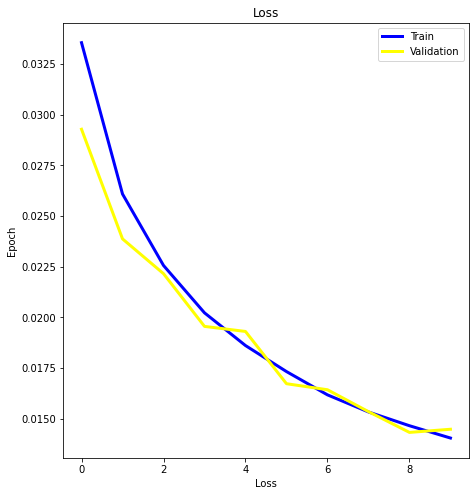

In [18]:
fig = plt.figure(figsize=(16, 8))


# loss
ax = fig.add_subplot(121)
ax.set_title('Loss')
ax.set_xlabel('Loss')
ax.set_ylabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='blue', linewidth=3)
plt.plot(val_loss, label='Validation', color='yellow', linewidth=3)

plt.legend()

In [20]:
reconstructeds, test_loss = evaluate(x_test, y_test, batch_size)
  
print('Test Loss %.4f ' % (test_loss))

Test Loss 0.0142 


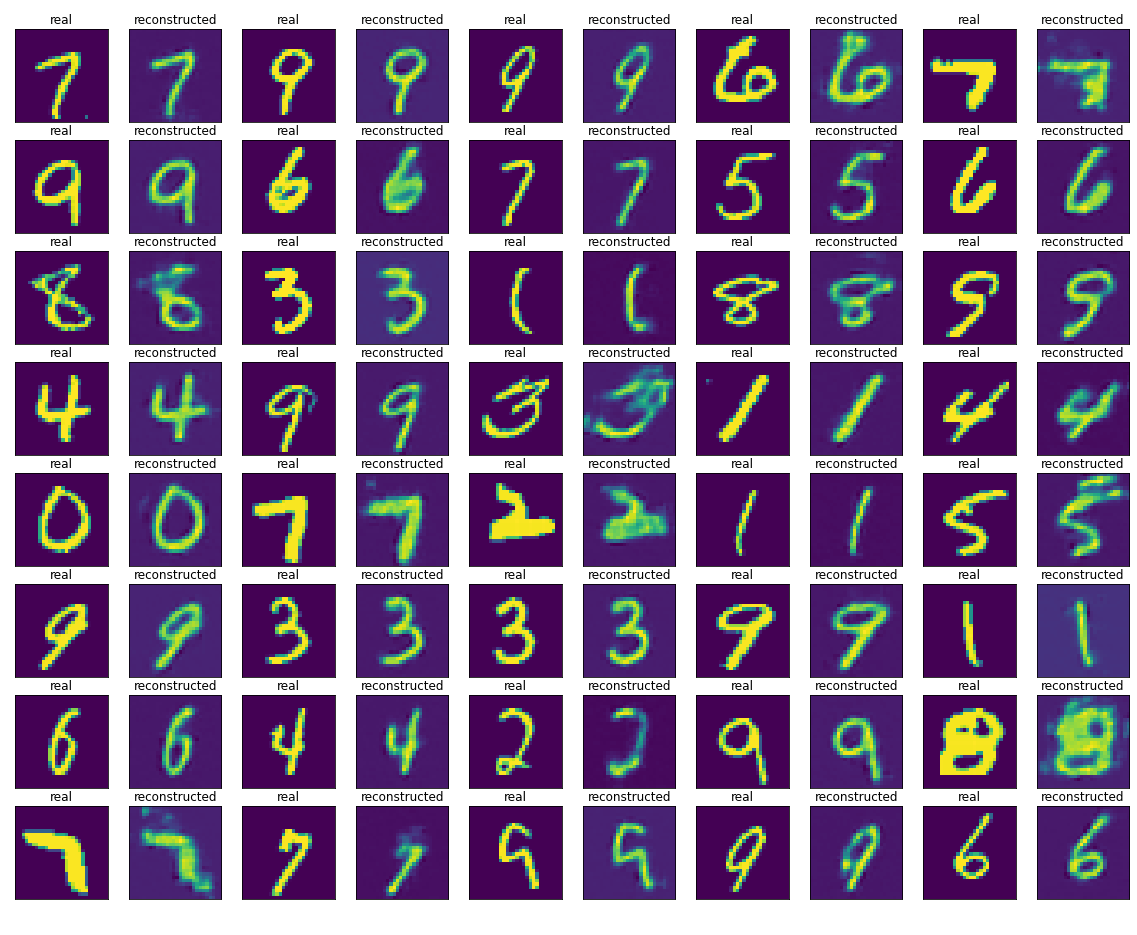

In [21]:
rows = 8
columns = 10
indices = np.random.choice(np.arange(len(x_test)), size=rows * columns // 2)
images = np.zeros((rows * columns // 2, 2, 28, 28))
images[:,0] = x_test[indices].reshape(rows * columns // 2, 28, 28)
images[:,1] = reconstructeds[indices].reshape(rows * columns // 2, 28, 28)
images = images.reshape(rows * columns, 28, 28) * 255

texts = np.zeros((rows * columns // 2, 2), dtype=object)
texts[:,0] = np.array(['Real' for _ in range(rows * columns // 2)])
texts[:,1] = np.array(['Reconstructed' for _ in range(rows * columns // 2)])
texts = texts.reshape(rows * columns)

fig = plt.figure(figsize=(2 * columns, 2 * rows))

for i in range(columns * rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.set_title(texts[i])
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(images[i].reshape((28, 28)))

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_frame_on(False)
plt.show()

In [22]:
with torch.no_grad():
        
    model.eval()  # validation phase

    inds = np.arange(len(x_test))

    iters_per_epoch = int(np.ceil(1.0 * len(x_test) / batch_size))

    epoch_loss = 0

    features = []
    reconstructeds = []
    loss = 0

    # iterating over the whole training set
    for iter in range(iters_per_epoch):

        batch_inds = inds[iter * batch_size: min(len(inds), (iter + 1) * batch_size)]

        # reshaping placeholders
        if len(batch_inds) != len(batch_x_placeholder):
            batch_x_placeholder.resize_([len(batch_inds), 1, 28, 28])

        batch_x_placeholder.copy_(torch.Tensor(x_test[batch_inds, np.newaxis, :, :]))

        b_decision, b_loss = model(batch_x_placeholder)
        b_decision = b_decision.flatten(1).cpu().numpy()
    
        epoch_loss += float(b_loss) / iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
        reconstructeds.append(b_decision)
    
    features = np.concatenate(reconstructeds)    


In [23]:
centers = np.zeros((10, features.shape[1]))
y_test = y_test.astype(int)
features.shape

(21000, 784)

In [24]:
for label in range(10):
    centers[label] = features[y_test == label].mean(axis=0)

In [25]:
from sklearn.cluster import MiniBatchKMeans

clustering = MiniBatchKMeans(n_clusters=10, batch_size=batch_size, verbose=2, init=centers, n_init=1)

In [26]:
_ = clustering.fit(features)

Init 1/1 with method: [[-1.0453620e-03  8.8252791e-04 -3.4297194e-04 ... -4.6194522e-04
  -2.2441361e-04  5.4986426e-04]
 [-7.9072476e-04  5.8463833e-04 -9.7722141e-04 ...  1.0964462e-04
  -1.4116145e-04 -3.0970597e-04]
 [-1.3043650e-03  1.3764198e-03 -1.5932863e-05 ...  1.8465858e-03
   1.0808652e-03  1.2180100e-03]
 ...
 [-1.0742944e-03  2.9790432e-03  2.9880225e-03 ...  1.3758373e-03
   2.0981811e-04  6.2451279e-04]
 [-2.1170042e-03  8.6732663e-04 -4.5406769e-04 ... -4.7814348e-04
   4.3197314e-04 -2.8230887e-04]
 [-2.0215847e-03  5.1291886e-04  1.1014946e-04 ...  1.8754640e-03
   2.6239539e-04  1.4916233e-04]]
Inertia for init 1/1: 5938.710449
Minibatch iteration 1/32900: mean batch inertia: 33.263985, ewa inertia: 33.263985 
Minibatch iteration 2/32900: mean batch inertia: 34.021156, ewa inertia: 33.268600 
Minibatch iteration 3/32900: mean batch inertia: 33.088478, ewa inertia: 33.267502 
Minibatch iteration 4/32900: mean batch inertia: 31.904224, ewa inertia: 33.259193 
Minibatc

In [27]:
matching_matrix = np.zeros((10, 10))

In [28]:
clusters = clustering.predict(features)

Computing label assignment and total inertia


In [29]:
for cluster in range(10):
    for label in range(10):
        matching_matrix[cluster, label] = (y_test[clusters == cluster] == label).sum()

Text(0, 0.5, 'Cluster')

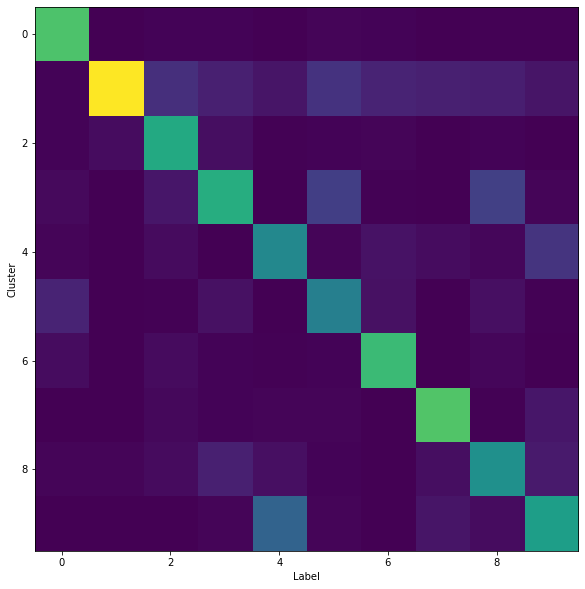

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(matching_matrix.astype(int))
plt.xlabel('Label')
plt.ylabel('Cluster')

In [31]:
print('accuracy:', np.diagonal(matching_matrix).sum() / matching_matrix.sum())

accuracy: 0.6807619047619048
